Chiara Barbieri -- 517096

Lorenzo Zoppelletto -- 516124

# Data collection




## Needed libraries

Install the library PRAW to work with Reddit API.

In [ ]:
!pip install praw

In [ ]:
# Standard
import re
import json
from datetime import datetime

# Data handling
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Reddit
import requests
import praw

# NLP
import nltk
from nltk import FreqDist
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer

# NLTK resources
nltk.download('omw-1.4')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# Dropping the warning
import warnings
warnings.filterwarnings("ignore")

## Accessing Reddit credentials


Downloading Reddit credentials from a personal file

In [ ]:
!gdown 1UK21LgcuLxS1E6SzduluWj96oJDciHBS --output reddit_credentials.json

Downloading...
From: https://drive.google.com/uc?id=1UK21LgcuLxS1E6SzduluWj96oJDciHBS
To: /content/reddit_credentials.json
100% 146/146 [00:00<00:00, 500kB/s]


In [ ]:
with open("reddit_credentials.json") as f:
    credentials = json.load(f)

In [ ]:
reddit = praw.Reddit(client_id=credentials['CLIENT_ID'],
                     client_secret=credentials['SECRET_TOKEN'],
                     password=credentials['PASSWORD'],
                     user_agent='Tutorial by /user/SMA202324',
                     username=credentials['USERNAME'],
                     check_for_async=False)

print(reddit.user.me())

chiaraUni_unipv


## Collecting posts

We select che subreddit *running* (macro-subject of our research)

In [ ]:
srname = 'running'
sr = reddit.subreddit(srname)

Collecting a maximum of 1000 posts with the most trending content about running to understand the main topics discussed.

In [ ]:
submissions_top_year = list(sr.top(time_filter='year', limit=200)) # Top posts of the current year
submissions_top_month = list(sr.top(time_filter='month', limit=200)) # Top posts of the current month
submissions_top_all = list(sr.top(time_filter='all', limit=200)) # All-time top posts
submissions_hot = list(sr.hot(limit=200)) # Finding posts that have been recently upvoted
submissions_new = list(sr.new(limit=200)) # Finding new posts.

# Include ALL the lists in concatenation
all_submissions = (submissions_top_year + submissions_top_month + submissions_top_all + submissions_hot + submissions_new)
unique_submissions = {sub.id: sub for sub in all_submissions}.values()

In [ ]:
print(f"Total submissions collected: {len(unique_submissions)}")
print(f"Date range: {min(datetime.fromtimestamp(sub.created_utc) for sub in unique_submissions)} to {max(datetime.fromtimestamp(sub.created_utc) for sub in unique_submissions)}")

Total submissions collected: 600
Date range: 2012-02-24 14:19:25 to 2025-08-30 05:01:18


To narrow the research to topics of interest, we select a few keywords based on the following topics:
- **Peaks of interest in running throughout the year**. It can be related to general behaviour with no specific purpose or for a meaningful reason, such as January for New Year’s resolutions, Spring to get ready for Summer, marathon training, 10k race...
- Analyze whether runners talk more about **positive aspects** (e.g. happy, achievements) **or negative ones** (e.g. injuries, fatigue).
- **Impact of external events** (e.g pandemic, lockdown, extreme weather events) on running-related content.

In [ ]:
# Keywords for the peaks of interest in running throughout the year

keyword_peakInterest_generalInterest = "jogging OR start running OR get in shape OR beginner"
keyword_peakInterest_race = "marathon OR half marathon OR 10k OR 5k OR couch to 5k OR C25K"
keyword_peakInterest_resolution = "motivation OR New Year OR January"
keyword_peakInterest_seasonal = "winter running OR summer running OR spring running OR fall running OR cold OR hot OR heat OR snow OR rain"

In [ ]:
# Keywords for sentiment on running (Note: PB stands for "Personal Best" and PR stands for "Personal Record")

keyword_sentiment_positive = "happy OR achievement OR fun OR PB OR personal best OR progress OR PR OR personal record OR love running OR enjoy OR runner's high OR satisfied OR goal OR great"
keyword_sentiment_negative = "injury OR knee pain OR joint pain OR stress OR fatigue OR overtraining OR burnout OR hate running OR can't run"

In [ ]:
# Keywords for impact of external events

keywords_externalEvents_lockdown = "lockdown OR covid OR pandemic OR quarantine OR indoor running OR treadmill OR home workout OR social distancing"
keywords_externalEvents_weather = "wildfire OR air quality OR extreme heat OR ice OR storm OR heat wave OR wind OR flooded OR smoke"

Collecting posts will be done exploiting the following function.

In [ ]:
def collect_submissions_by_keywords(subreddit_name, keywords, category_name, limit=100, sort="relevance"):
    submissions_data = []

    for submission in reddit.subreddit(subreddit_name).search(keywords, limit=limit, sort=sort):
        submission_data = {
          'author': '',
          'author_flair_text': '',
          'clicked': submission.clicked,
          'comments': submission.comments,
          'created_utc': submission.created_utc,
          'distinguished': submission.distinguished,
          'edited': submission.edited,
          'id': submission.id,
          'is_original_content': submission.is_original_content,
          'is_self': submission.is_self,
          'link_flair_template_id': '',
          'link_flair_text': '',
          'locked': submission.locked,
          'name': submission.name,
          'num_comments': submission.num_comments,
          'over_18': submission.over_18,
          'permalink': submission.permalink,
          'poll_data': '',
          'saved': submission.saved,
          'score': submission.score,
          'selftext': '',
          'spoiler': submission.spoiler,
          'stickied': submission.stickied,
          'subreddit': submission.subreddit,
          'title': submission.title,
          'upvote_ratio': submission.upvote_ratio,
          'url': submission.url,
          'matched_keywords': keywords,
          'category': category_name
        }

        optional_fields = ['author', 'author_flair_text', 'link_flair_text', 'link_flair_template_id', 'selftext', 'poll_data']

        for field in optional_fields:
            try:
                submission_data[field] = getattr(submission, field)
            except AttributeError:
                pass

        submissions_data.append(submission_data)

    return submissions_data

Now, we can retrieve the posts based on the keywords defined above.

In [ ]:
# Create an empty list to save all the dictionaries with the post's data
submissions_data_peakInterest = []
submissions_data_sentiment = []
submissions_data_externalEvents = []

# Peak Interest keywords
peak_keywords_with_categories = [
    (keyword_peakInterest_generalInterest, "general_interest"),
    (keyword_peakInterest_race, "race_training"),
    (keyword_peakInterest_resolution, "new_year_resolution"),
    (keyword_peakInterest_seasonal, "seasonal_running")
]
for keywords, category in peak_keywords_with_categories:
    data = collect_submissions_by_keywords(srname, keywords, category, limit=100)
    submissions_data_peakInterest.extend(data)

# Sentiment keywords
sentiment_keywords_with_categories = [
    (keyword_sentiment_positive, "positive_sentiment"),
    (keyword_sentiment_negative, "negative_sentiment")
]
for keywords, category in sentiment_keywords_with_categories:
    data = collect_submissions_by_keywords(srname, keywords, category, limit=100)
    submissions_data_sentiment.extend(data)

# External events
event_keywords_with_categories = [
    (keywords_externalEvents_lockdown, "pandemic_lockdown"),
    (keywords_externalEvents_weather, "weather_events")
]
for keywords, category in event_keywords_with_categories:
    data = collect_submissions_by_keywords(srname, keywords, category, limit=100)
    submissions_data_externalEvents.extend(data)

For each set of keywords, the number of posts collected is the following:

In [ ]:
# Number of posts collected on peak of interest
print(f"Num. of posts on peaks of interest: {len(submissions_data_peakInterest)}")

# Number of posts collected on sentiment
print(f"Num. of posts on sentiment: {len(submissions_data_sentiment)}")

# Number of posts collected on external events
print(f"Num. of posts on external events: {len(submissions_data_externalEvents)}")

Num. of posts on peaks of interest: 300
Num. of posts on sentiment: 200
Num. of posts on external events: 200


Now we can create a dataframe that collects all the retrieved posts.

In [ ]:
# Collecting all submissions
all_submissions = submissions_data_peakInterest + submissions_data_sentiment + submissions_data_externalEvents
# Removing duplicates from the submissions
unique_submissions = {sub["id"]: sub for sub in all_submissions}.values()

df = pd.DataFrame(unique_submissions)

In [ ]:
df

,author,author_flair_text,clicked,comments,created_utc,distinguished,edited,id,is_original_content,is_self,...,score,selftext,spoiler,stickied,subreddit,title,upvote_ratio,url,matched_keywords,category
0,siliwei,None,False,"(lvhaloq, lvhmdan, lviek0u, lvjsb0d, lvl7jab, ...",1.730766e+09,None,1730767344.0,1gjtwpt,False,True,...,115,If you want a complete backstory of how I star...,False,False,running,How I ran a sub 2 hour half marathon as a begi...,0.71,https://www.reddit.com/r/running/comments/1gjt...,jogging OR start running OR get in shape OR be...,general_interest
1,Which_Cat_4752,None,False,"(h0ws13w, h0x5bke, h0xn1e1, h0xpbn3, h0wyu0g, ...",1.623074e+09,None,1623235823.0,nud8sl,False,True,...,8,Hi newbie seeking advice here!\n\nI am thinkin...,False,False,running,thinking of running regularly but still overwe...,0.69,https://www.reddit.com/r/running/comments/nud8...,jogging OR start running OR get in shape OR be...,general_interest
2,TheMundaneChanges,None,False,"(ftrntlo, ftro3k6, ftrnxes, ful5t1r, fulkxv4)",1.591930e+09,None,False,h7ci70,False,True,...,1,"I feel like I’ve been training for ages, and s...",False,False,running,Runner in training,0.57,https://www.reddit.com/r/running/comments/h7ci...,jogging OR start running OR get in shape OR be...,general_interest
3,ChellaBella1219,None,False,"(iw51lan, iw54j7k, iw54t17, iw4zj5z, iw5a9xh, ...",1.668298e+09,None,1668298357.0,ytmgx7,False,True,...,552,Race Information\n\nName: Richmond Half Marath...,False,False,running,"Race Report from a Slow, Beginner, Struggle Ru...",0.96,https://www.reddit.com/r/running/comments/ytmg...,jogging OR start running OR get in shape OR be...,general_interest
4,Squints753,None,False,"(c43teeg, c43whdo)",1.332440e+09,None,False,r8oop,False,True,...,1,I decided to take up running recently as a way...,False,False,running,"In week 3 of beginner's program, can't run mor...",1.00,https://www.reddit.com/r/running/comments/r8oo...,jogging OR start running OR get in shape OR be...,general_interest
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
517,MudHoundX,None,False,"(dwgpxyr, dwgq2hz, dwh1c1n, dwh31rd, dwgw4mh, ...",1.522307e+09,None,False,87z8my,False,True,...,76,I know smoking is bad for you and quitting wil...,False,False,running,Smoking and Running,0.85,https://www.reddit.com/r/running/comments/87z8...,wildfire OR air quality OR extreme heat OR ice...,weather_events
518,kalebananasmoothiez,None,False,"(i1w6g24, i1w3cfo, i1w77y5, i1x94sr, i1w2q94, ...",1.648094e+09,None,False,tlx4hy,False,True,...,26,and i mean sweaty. i currently use airpods and...,False,False,running,what are the BEST high quality audio earbuds f...,0.80,https://www.reddit.com/r/running/comments/tlx4...,wildfire OR air quality OR extreme heat OR ice...,weather_events
519,Izual_Rebirth,None,False,"(csp684u, csp69i8, csp9w0e, csp77m7, cspb2cb, ...",1.435786e+09,None,False,3bsugn,False,True,...,110,Been running for a few months and it was a lov...,False,False,running,Tried to run in the heat today. Opps... big mi...,0.90,https://www.reddit.com/r/running/comments/3bsu...,wildfire OR air quality OR extreme heat OR ice...,weather_events
520,2020420,None,False,"(e0w7frc, e0wd4rx, e0w9qju, e0wamhq, e0wgc7j, ...",1.529350e+09,None,False,8s2951,False,True,...,406,[http://www.nbnationalsout.com/eprofile.php?ev...,False,False,running,Katelyn Tuohy - High school #6 mile all-time: ...,0.96,https://www.reddit.com/r/running/comments/8s29...,wildfire OR air quality OR extreme heat OR ice...,weather_events


# Preprocessing steps

First thing first, we check null values.

In [ ]:
df.isnull().sum()

,0
author,0
author_flair_text,499
clicked,0
comments,0
created_utc,0
distinguished,513
edited,0
id,0
is_original_content,0
is_self,0


Given that the attributes "author_flair_text", "distinguished", "link_flair_text" have all null values, we drop them

In [ ]:
df.drop(['author_flair_text', 'distinguished', 'link_flair_text'], axis=1, inplace=True)

Since there can be multiple different ways of expressing the presence of null values:

In [ ]:
fake_null_values = ["nan", "NaN", "NAN", "null", "None", ""]

for col in df.columns:
  uniques = df[col].astype(str).str.strip().unique()
  if any(value in fake_null_values for value in uniques):
    print(col)

link_flair_template_id
poll_data
selftext


Moreover, we also drop the columns that have fake null values

In [ ]:
df.drop(['link_flair_template_id', 'poll_data'], axis=1, inplace=True)

The only column that we don't drop is "selftext", bacause it will be needed later on.

Now we have a clean dataset from null values, as we can see below.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 522 entries, 0 to 521
Data columns (total 24 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   author               522 non-null    object 
 1   clicked              522 non-null    bool   
 2   comments             522 non-null    object 
 3   created_utc          522 non-null    float64
 4   edited               522 non-null    object 
 5   id                   522 non-null    object 
 6   is_original_content  522 non-null    bool   
 7   is_self              522 non-null    bool   
 8   locked               522 non-null    bool   
 9   name                 522 non-null    object 
 10  num_comments         522 non-null    int64  
 11  over_18              522 non-null    bool   
 12  permalink            522 non-null    object 
 13  saved                522 non-null    bool   
 14  score                522 non-null    int64  
 15  selftext             522 non-null    obj

## Clean texts

Combining the title of the post with "selftext" to have a unique and complete text.

In [ ]:
df['text'] = df.apply(lambda row: row['title'] + row['selftext'] if pd.notna(row['selftext']) else row['title'], axis=1)

On the values of the attribute "text" we want to apply a few steps of text cleaning.

In [ ]:
def preprocess_data(data):
    data = data.astype(str).str.replace(r'https?://[^\s]+|www\.[^\s]+|[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}(?:/[^\s]*)?', ' ', regex=True) # cleaning all kinds of links from the text column.
    data = data.astype(str).str.replace(r"[^\w\s]", " ", regex=True) # cleaning special characters using regular expressions (we keep the numbers)
    lower_text = data.str.lower() # lowercase all the text

    # tokenization
    w_tokenizer= TweetTokenizer() # Apply tokenization to extract the single words
    words = lower_text.apply(w_tokenizer.tokenize)

    # delete english stopwords
    stop_words = set(stopwords.words('english'))
    words = words.apply(lambda toks: [w for w in toks if w not in stop_words])

    return pd.DataFrame(words)

In [ ]:
# Apply the preprocessing function to the column "text"
pre_r= preprocess_data(df['text'])
df['text_proc']= pre_r

Below we can see the difference between the original text and the cleaned text

In [ ]:
df.loc[454]['text']

'Exclusive starting wave for sub-25 men only?Hello, everyone! I (F) am running a 5k next week, and have been training for a sub-20 finish. 5 days out, the organizer announced that because the number of runners exceeds their initial limit, there will be two starting waves: one exclusively for men running sub-25, and one for the rest.\n\nNow, I feel a bit disheartened about this, mostly because it’s more of a local run, so I don’t expect more than 5-10 women to be running sub-20, with a few of those going around the 18-minute mark, so it’s probably going to be a bit of a lonely run for me. I reached out to the organizers to ask if it was possible to put all sub-25 runners in the same wave (which I think would be fair), and got the following response (not word by word):\n\n“It’s only going to be fair if the women compete in a single race under the same conditions, without the help of men. Then, the women will decide amongst themselves who comes out victorious. All of the female runners we

In [ ]:
df.loc[454]['text_proc']

['exclusive',
 'starting',
 'wave',
 'sub',
 '25',
 'men',
 'hello',
 'everyone',
 'f',
 'running',
 '5k',
 'next',
 'week',
 'training',
 'sub',
 '20',
 'finish',
 '5',
 'days',
 'organizer',
 'announced',
 'number',
 'runners',
 'exceeds',
 'initial',
 'limit',
 'two',
 'starting',
 'waves',
 'one',
 'exclusively',
 'men',
 'running',
 'sub',
 '25',
 'one',
 'rest',
 'feel',
 'bit',
 'disheartened',
 'mostly',
 'local',
 'run',
 'expect',
 '5',
 '10',
 'women',
 'running',
 'sub',
 '20',
 'going',
 'around',
 '18',
 'minute',
 'mark',
 'probably',
 'going',
 'bit',
 'lonely',
 'run',
 'reached',
 'organizers',
 'ask',
 'possible',
 'put',
 'sub',
 '25',
 'runners',
 'wave',
 'think',
 'would',
 'fair',
 'got',
 'following',
 'response',
 'word',
 'word',
 'going',
 'fair',
 'women',
 'compete',
 'single',
 'race',
 'conditions',
 'without',
 'help',
 'men',
 'women',
 'decide',
 'amongst',
 'comes',
 'victorious',
 'female',
 'runners',
 'asked',
 'thrilled',
 'unique',
 'occasion',


Now we can drop the column "selftext" since it has null values. However, we are going to keep all the other columns to have a reference to the original dataset in case of inconsistencies later on.

In [ ]:
df.drop(['selftext'], axis=1, inplace=True)

## Timeline normalization

In [ ]:
# converting to datetime
df['created_utc'] = df['created_utc'].apply(lambda x: datetime.fromtimestamp(x))

Sorting the dataset by the datatime (from earlier dates to latest)

In [ ]:
df = df.sort_values(by=['created_utc']).reset_index(drop=True)

Extracting the year, month, day of the week (dow) and the hour

In [ ]:
df['year'] = df['created_utc'].dt.year
df['month'] = df['created_utc'].dt.month
df['dow'] = df['created_utc'].dt.day_name()
df['hour'] = df['created_utc'].dt.hour

## Counting the comments as a measure of the interactions with a certain post

Extracting the IDs from the "comments" to get a list, making the IDs of the users who made the comment accessible, as well as countable.

In [ ]:
def extract_ids(comment_list):
    l = []
    for comment in comment_list:
      l.append(str(comment))
    return l

In [ ]:
df['comments_str'] = df['comments'].apply(extract_ids)

Counting the number of comments in each list to check the amount of interactions with a certain post

In [ ]:
df['count_comments'] = df.comments_str.apply(lambda x: len(x)) # count the comments

# Downloading the clean data

In [ ]:
df

,author,clicked,comments,created_utc,edited,id,is_original_content,is_self,locked,name,...,matched_keywords,category,text,text_proc,year,month,dow,hour,comments_str,count_comments
0,Can37,False,"(c34ja51, c34jbyb, c34hxzy, c34j6r1, c34islj, ...",2011-12-02 01:59:55,False,mwy3x,False,False,False,t3_mwy3x,...,winter running OR summer running OR spring run...,seasonal_running,Comprehensive guide to what to wear for winter...,"[comprehensive, guide, wear, winter, running]",2011,12,Friday,1,"[c34ja51, c34jbyb, c34hxzy, c34j6r1, c34islj, ...",36
1,foreveranewbie,False,"(c38dn10, c38egje, c38dpkt, c38e9ls, c38eur1, ...",2011-12-15 19:12:23,False,ne3wl,False,True,False,t3_ne3wl,...,marathon OR half marathon OR 10k OR 5k OR couc...,race_training,c242k Training PlanThis is [The Plan](https://...,"[c242k, training, planthis, plan, based, advic...",2011,12,Thursday,19,"[c38dn10, c38egje, c38dpkt, c38e9ls, c38eur1, ...",6
2,PKLKickballer,False,"(c3tv88i, c3tuw8z, c3tvf0y, c3tyhxz, c3txb5h, ...",2012-02-22 17:43:22,1329936202.0,q15p3,False,True,False,t3_q15p3,...,wildfire OR air quality OR extreme heat OR ice...,weather_events,You shouldn't be winded!I've seen a few posts ...,"[winded, seen, posts, week, newer, runners, ge...",2012,2,Wednesday,17,"[c3tv88i, c3tuw8z, c3tvf0y, c3tyhxz, c3txb5h, ...",61
3,Squints753,False,"(c43teeg, c43whdo)",2012-03-22 18:15:24,False,r8oop,False,True,False,t3_r8oop,...,jogging OR start running OR get in shape OR be...,general_interest,"In week 3 of beginner's program, can't run mor...","[week, 3, beginner, program, run, 2, minutes, ...",2012,3,Thursday,18,"[c43teeg, c43whdo]",2
4,DingDongerer,False,"(c66n73t, c66ppwl, c66mn5u, c66norv, c66sn5s, ...",2012-09-11 15:15:03,1347376746.0,zpmd7,False,True,False,t3_zpmd7,...,lockdown OR covid OR pandemic OR quarantine OR...,pandemic_lockdown,As a runner I struggle with running vs. liftin...,"[runner, struggle, running, vs, lifting, like,...",2012,9,Tuesday,15,"[c66n73t, c66ppwl, c66mn5u, c66norv, c66sn5s, ...",52
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
517,maggisaucee,False,"(n46rzms, n46w4ry, n46sup6, n46wxwl, n46yl68, ...",2025-07-20 13:56:46,1753036888.0,1m4pjwv,False,True,False,t3_1m4pjwv,...,wildfire OR air quality OR extreme heat OR ice...,weather_events,Running in hot/humid weatherQuestion for runne...,"[running, hot, humid, weatherquestion, runners...",2025,7,Sunday,13,"[n46rzms, n46w4ry, n46sup6, n46wxwl, n46yl68, ...",242
518,levi0xa,False,"(n5tfwhe, n5tjbem, n5te2q6, n5tgku7, n5thnyg, ...",2025-07-29 11:13:57,False,1mc8mbu,False,True,False,t3_1mc8mbu,...,injury OR knee pain OR joint pain OR stress OR...,negative_sentiment,How do you continue running long runs without ...,"[continue, running, long, runs, without, letti...",2025,7,Tuesday,11,"[n5tfwhe, n5tjbem, n5te2q6, n5tgku7, n5thnyg, ...",242
519,stonerbobo,False,"(n8qc3qm, n8qf0ue, n8qwwnx, n8qlx6n, n8qcttt, ...",2025-08-14 21:23:04,1755239087.0,1mqdpwx,False,True,False,t3_1mqdpwx,...,lockdown OR covid OR pandemic OR quarantine OR...,pandemic_lockdown,How much running is too much - a study on inju...,"[much, running, much, study, injuryfound, cool...",2025,8,Thursday,21,"[n8qc3qm, n8qf0ue, n8qwwnx, n8qlx6n, n8qcttt, ...",50
520,s_dalbiac,False,"(n9wsu78, n9wumcs, n9wx2si, n9wuf2c, n9wtugk, ...",2025-08-21 15:26:26,False,1mwe43b,False,True,False,t3_1mwe43b,...,injury OR knee pain OR joint pain OR stress OR...,negative_sentiment,How do you stop yourself going too fast on eas...,"[stop, going, fast, easy, runs, got, back, run...",2025,8,Thursday,15,"[n9wsu78, n9wumcs, n9wx2si, n9wuf2c, n9wtugk, ...",207


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 522 entries, 0 to 521
Data columns (total 31 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   author               522 non-null    object        
 1   clicked              522 non-null    bool          
 2   comments             522 non-null    object        
 3   created_utc          522 non-null    datetime64[ns]
 4   edited               522 non-null    object        
 5   id                   522 non-null    object        
 6   is_original_content  522 non-null    bool          
 7   is_self              522 non-null    bool          
 8   locked               522 non-null    bool          
 9   name                 522 non-null    object        
 10  num_comments         522 non-null    int64         
 11  over_18              522 non-null    bool          
 12  permalink            522 non-null    object        
 13  saved                522 non-null  

In [ ]:
#from google.colab import drive
#drive.mount("/content/drive", force_remount=True)

#df.to_csv("/content/drive/MyDrive/AI/Year 3/Web and social networks search and analysis/Project/runnersData.csv", index=False)

Mounted at /content/drive


# Graphs to visualize the data

Here we download the final dataset, so that for the data exploration, not all the code has to be run.

In [ ]:
!gdown 1n2TiGFN-rDDfrh5NrF-LDJOfs47rmaYp -O runner_data.csv

Downloading...
From: https://drive.google.com/uc?id=1n2TiGFN-rDDfrh5NrF-LDJOfs47rmaYp
To: /content/runner_data.csv
100% 2.63M/2.63M [00:00<00:00, 76.2MB/s]


In [ ]:
df = pd.read_csv('runner_data.csv')
df

,author,clicked,comments,created_utc,edited,id,is_original_content,is_self,locked,name,...,matched_keywords,category,text,text_proc,year,month,dow,hour,comments_str,count_comments
0,Can37,False,<praw.models.comment_forest.CommentForest obje...,2011-12-02 01:59:55,False,mwy3x,False,False,False,t3_mwy3x,...,winter running OR summer running OR spring run...,seasonal_running,Comprehensive guide to what to wear for winter...,"['comprehensive', 'guide', 'wear', 'winter', '...",2011,12,Friday,1,"['c34ja51', 'c34jbyb', 'c34hxzy', 'c34j6r1', '...",36
1,foreveranewbie,False,<praw.models.comment_forest.CommentForest obje...,2011-12-15 19:12:23,False,ne3wl,False,True,False,t3_ne3wl,...,marathon OR half marathon OR 10k OR 5k OR couc...,race_training,c242k Training PlanThis is [The Plan](https://...,"['c242k', 'training', 'planthis', 'plan', 'bas...",2011,12,Thursday,19,"['c38dn10', 'c38egje', 'c38dpkt', 'c38e9ls', '...",6
2,PKLKickballer,False,<praw.models.comment_forest.CommentForest obje...,2012-02-22 17:43:22,1329936202.0,q15p3,False,True,False,t3_q15p3,...,wildfire OR air quality OR extreme heat OR ice...,weather_events,You shouldn't be winded!I've seen a few posts ...,"['winded', 'seen', 'posts', 'week', 'newer', '...",2012,2,Wednesday,17,"['c3tv88i', 'c3tuw8z', 'c3tvf0y', 'c3tyhxz', '...",61
3,Squints753,False,<praw.models.comment_forest.CommentForest obje...,2012-03-22 18:15:24,False,r8oop,False,True,False,t3_r8oop,...,jogging OR start running OR get in shape OR be...,general_interest,"In week 3 of beginner's program, can't run mor...","['week', '3', 'beginner', 'program', 'run', '2...",2012,3,Thursday,18,"['c43teeg', 'c43whdo']",2
4,DingDongerer,False,<praw.models.comment_forest.CommentForest obje...,2012-09-11 15:15:03,1347376746.0,zpmd7,False,True,False,t3_zpmd7,...,lockdown OR covid OR pandemic OR quarantine OR...,pandemic_lockdown,As a runner I struggle with running vs. liftin...,"['runner', 'struggle', 'running', 'vs', 'lifti...",2012,9,Tuesday,15,"['c66n73t', 'c66ppwl', 'c66mn5u', 'c66norv', '...",52
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
517,maggisaucee,False,<praw.models.comment_forest.CommentForest obje...,2025-07-20 13:56:46,1753036888.0,1m4pjwv,False,True,False,t3_1m4pjwv,...,wildfire OR air quality OR extreme heat OR ice...,weather_events,Running in hot/humid weatherQuestion for runne...,"['running', 'hot', 'humid', 'weatherquestion',...",2025,7,Sunday,13,"['n46rzms', 'n46w4ry', 'n46sup6', 'n46wxwl', '...",242
518,levi0xa,False,<praw.models.comment_forest.CommentForest obje...,2025-07-29 11:13:57,False,1mc8mbu,False,True,False,t3_1mc8mbu,...,injury OR knee pain OR joint pain OR stress OR...,negative_sentiment,How do you continue running long runs without ...,"['continue', 'running', 'long', 'runs', 'witho...",2025,7,Tuesday,11,"['n5tfwhe', 'n5tjbem', 'n5te2q6', 'n5tgku7', '...",242
519,stonerbobo,False,<praw.models.comment_forest.CommentForest obje...,2025-08-14 21:23:04,1755239087.0,1mqdpwx,False,True,False,t3_1mqdpwx,...,lockdown OR covid OR pandemic OR quarantine OR...,pandemic_lockdown,How much running is too much - a study on inju...,"['much', 'running', 'much', 'study', 'injuryfo...",2025,8,Thursday,21,"['n8qc3qm', 'n8qf0ue', 'n8qwwnx', 'n8qlx6n', '...",50
520,s_dalbiac,False,<praw.models.comment_forest.CommentForest obje...,2025-08-21 15:26:26,False,1mwe43b,False,True,False,t3_1mwe43b,...,injury OR knee pain OR joint pain OR stress OR...,negative_sentiment,How do you stop yourself going too fast on eas...,"['stop', 'going', 'fast', 'easy', 'runs', 'got...",2025,8,Thursday,15,"['n9wsu78', 'n9wumcs', 'n9wx2si', 'n9wuf2c', '...",207


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 522 entries, 0 to 521
Data columns (total 31 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   author               522 non-null    object 
 1   clicked              522 non-null    bool   
 2   comments             522 non-null    object 
 3   created_utc          522 non-null    object 
 4   edited               522 non-null    object 
 5   id                   522 non-null    object 
 6   is_original_content  522 non-null    bool   
 7   is_self              522 non-null    bool   
 8   locked               522 non-null    bool   
 9   name                 522 non-null    object 
 10  num_comments         522 non-null    int64  
 11  over_18              522 non-null    bool   
 12  permalink            522 non-null    object 
 13  saved                522 non-null    bool   
 14  score                522 non-null    int64  
 15  spoiler              522 non-null    boo

### Word cloud

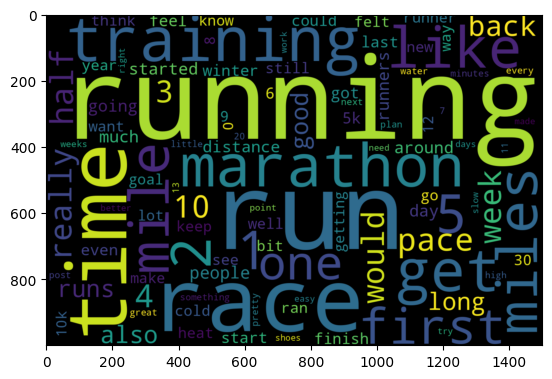

In [ ]:
# Finding all the words
all_words = [word for text in df['text_proc'] for word in eval(text)]

# Finding the frequency of each word in the text
fdist = FreqDist(all_words)

# Creating the cloud of words
wc = WordCloud(width=1500, height=1000, max_words=100).generate_from_frequencies(fdist)
plt.imshow(wc, interpolation="bilinear")
plt.show()